<a href="https://colab.research.google.com/github/GajananKuchgave/EVA8_Assignments/blob/main/MNIST_2_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Neural Network to detect MNIST data and Sum of MNIST number + Random Number

#Libraries

In [1]:
#Import required libraries
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader

import torch.nn.functional as F
import torch.optim as optim


import matplotlib.pyplot as plt
import numpy as np
import random

#Use Cuda as a device Type

In [2]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


#Download the Training and Testing Dataset

In [3]:
# Train set
MNIST_train_set = torchvision.datasets.MNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences
    ])
)

print("Training set size",len(MNIST_train_set))

MNIST_test_set = torchvision.datasets.MNIST(
    root='./data'
    ,train=False
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences
    ])
)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training set size 60000


#Customized dataset to read both random number and MNIST data

In [4]:
class MNISTandRandomDataset(Dataset):
  def __init__(self, MNIST_dataset):
    self.MNIST_dataset = MNIST_dataset

  def __getitem__(self, index):
    image, label = self.MNIST_dataset[index]
    randNum = random.randint(0,9)

 #Creating one hot encoding for random number 
    one_hot_randNumber = F.one_hot(torch.arange(0, 10)) 
    #add actual label and random number
    sum_label = label + randNum
    return image, label, one_hot_randNumber[randNum], sum_label

  def __len__(self):
    return len(self.MNIST_dataset)

#Training and Testing Dataset

In [5]:

train_data_set = MNISTandRandomDataset(MNIST_train_set)
test_data_set = MNISTandRandomDataset(MNIST_test_set)

In [7]:
next(iter(train_data_set))

(tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.424

#Dataloader for both batch based training and Testing


In [8]:
train_loader = torch.utils.data.DataLoader(train_data_set, batch_size = 128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data_set,batch_size=128)

In [9]:
# Checking the dataset
batch = next(iter(train_loader))
image, label, random_num, sum_label = batch
print(image.shape,label,random_num, sum_label)

torch.Size([128, 1, 28, 28]) tensor([5, 1, 5, 9, 4, 5, 2, 3, 5, 6, 3, 1, 6, 0, 4, 9, 5, 5, 8, 7, 5, 4, 0, 4,
        8, 0, 8, 7, 4, 2, 8, 1, 6, 8, 2, 8, 3, 5, 7, 8, 8, 5, 5, 5, 8, 0, 9, 8,
        6, 3, 7, 0, 3, 2, 4, 4, 2, 3, 4, 7, 0, 1, 5, 9, 8, 7, 3, 6, 7, 2, 6, 8,
        4, 1, 0, 8, 0, 8, 7, 0, 9, 0, 6, 4, 3, 7, 4, 6, 3, 1, 3, 3, 0, 9, 2, 9,
        8, 4, 3, 1, 9, 4, 6, 5, 5, 8, 4, 9, 3, 6, 8, 1, 9, 4, 1, 2, 0, 4, 5, 5,
        0, 5, 2, 2, 9, 6, 4, 1]) tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 0]]) tensor([ 8,  7,  9, 10,  4, 14,  3,  4, 10, 15, 11,  7, 15,  3,  9,  9,  8, 13,
         9, 12, 14,  9,  8,  7, 13,  1, 11, 13, 10,  6, 11, 10, 11, 16,  9, 17,
         3,  7, 11, 14, 10,  8, 12,  6, 17,  7, 15, 13,  9,  7,  7,  4, 11,  7,
         5,  4,  4, 12,  7,  9,  7,  6,  5, 16, 13, 12, 11, 12,  8, 10,  6, 14,


#Network Class for MNIST and Random NN Model

In [10]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) 
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(128, 128, 3)
        self.conv6 = nn.Conv2d(128, 256, 3)
        self.conv7 = nn.Conv2d(256, 10, 3)

        self.fc1 = nn.Linear(20, 64)    
        # Total of 19 outputs for MNIST + Random output layer (0 - 18)           
        self.fc2 = nn.Linear(64, 19) 

    def forward(self, x, rand_num):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = F.relu(self.conv7(x))
        #x = x.view(-1, 10*3*3)
        x = torch.flatten(x,1)
  
        new_x = torch.cat((x, rand_num), dim=1)

        new_x = self.fc2(F.relu(self.fc1(new_x))) 

        return F.log_softmax(x, dim = 1), F.log_softmax(new_x, dim = 1)

#Taking Model from Network

In [11]:
model = Network()

#Training and Testing of a Model

In [12]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    epoch_loss = 0
    for batch_idx, (image, label, randNum, sum_label) in enumerate(pbar):
        image, label, randNum,sum_label = image.to(device), label.to(device),randNum.to(device),sum_label.to(device)
        optimizer.zero_grad()
        output, sum_output = model(image,randNum )
        mnist_loss = F.cross_entropy(output, label)
        sum_loss = F.cross_entropy(sum_output,sum_label)
        loss = (mnist_loss + sum_loss)/2
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'Training_loss={loss.item()} batch_id={batch_idx}')
    train_loss = epoch_loss / len(train_loader)
    return train_loss

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    sum_correct = 0
    with torch.no_grad():
        for image, label, randNum, sum_label in test_loader:
            image, label, randNum,sum_label = image.to(device), label.to(device),randNum.to(device),sum_label.to(device)
            output, sum_output = model(image, randNum)
            #test_loss += F.nll_loss(output, label, reduction='sum').item()  # sum up batch loss
            test_loss += (F.cross_entropy(output, label) + F.cross_entropy(sum_output, sum_label))/2
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            sum_pred = sum_output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(label.view_as(pred)).sum().item()
            sum_correct += pred.eq(sum_label.view_as(sum_pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    MNIST_Accuracy = 100. * correct/len(test_loader.dataset)
    Addtion_Accuracy = 100. * sum_correct/len(test_loader.dataset)
   
    print(f' set: Average loss: {test_loss:.3f},   MNIST Accuracy:{MNIST_Accuracy},   Addition_Accuracy:{Addtion_Accuracy}')
    print('\n')
    return test_loss

In [13]:
model = Network().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

train_loss_values = []
test_loss_values = []

for epoch in range(1, 11):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss = test(model, device, test_loader)

    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

Training_loss=1.5795272588729858 batch_id=468: 100%|██████████| 469/469 [00:32<00:00, 14.38it/s]


 set: Average loss: 0.013,   MNIST Accuracy:72.69,   Addition_Accuracy:8.13




Training_loss=1.2168940305709839 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.54it/s]


 set: Average loss: 0.010,   MNIST Accuracy:96.55,   Addition_Accuracy:9.76




Training_loss=1.1245989799499512 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.45it/s]


 set: Average loss: 0.009,   MNIST Accuracy:97.48,   Addition_Accuracy:10.09




Training_loss=1.0494039058685303 batch_id=468: 100%|██████████| 469/469 [00:26<00:00, 17.81it/s]


 set: Average loss: 0.008,   MNIST Accuracy:98.25,   Addition_Accuracy:10.17




Training_loss=0.9079716205596924 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.62it/s]


 set: Average loss: 0.007,   MNIST Accuracy:98.54,   Addition_Accuracy:10.28




Training_loss=0.7727746367454529 batch_id=468: 100%|██████████| 469/469 [00:24<00:00, 18.93it/s]


 set: Average loss: 0.006,   MNIST Accuracy:98.71,   Addition_Accuracy:10.01




Training_loss=0.639367938041687 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.52it/s]


 set: Average loss: 0.005,   MNIST Accuracy:98.69,   Addition_Accuracy:9.76




Training_loss=0.5288832783699036 batch_id=468: 100%|██████████| 469/469 [00:24<00:00, 19.03it/s]


 set: Average loss: 0.004,   MNIST Accuracy:98.88,   Addition_Accuracy:9.88




Training_loss=0.39607828855514526 batch_id=468: 100%|██████████| 469/469 [00:24<00:00, 18.77it/s]


 set: Average loss: 0.003,   MNIST Accuracy:99.01,   Addition_Accuracy:9.49




Training_loss=0.37397557497024536 batch_id=468: 100%|██████████| 469/469 [00:24<00:00, 18.78it/s]


 set: Average loss: 0.003,   MNIST Accuracy:99.09,   Addition_Accuracy:9.83




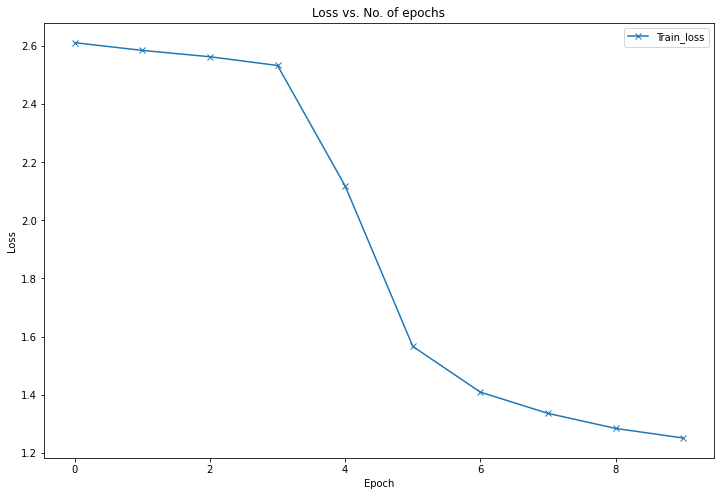

In [ ]:
import matplotlib.pyplot as plt
# matplotlib inline
plt.figure(figsize=(12, 8))
plt.plot(train_loss_values, '-x')
#plt.plot(test_loss_values, '-x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train_loss', 'Test_loss'])
plt.title('Loss vs. No. of epochs')
plt.savefig('Loss.png');